# Validation Unsafe-NET

In [1]:
import os
from pathlib import Path
import sys
from dataclasses import dataclass
import torch
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset
from model.multimodal_har_model import MultiModalHARModel
from validation.result_types import ValidationResults, ValidationBranchTuple, DatasetValidation
from validation.quantitative_metrics import evaluate_model
from validation.extract_embeddings import extract_embeddings
from consts.charts_constants import CHARTS_LABELS

2025-12-30 11:49:59,169 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2025-12-30 11:49:59,170 - INFO - Sentry initialized with environment: development


Loading config...
Loading secrets...


### Defining Support Methods

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def visualize_tsne(
    reduced_tsne: np.ndarray,
    labels: np.ndarray,
    num_classes: int,
    n_components: int = 2,
    title: str = "t-SNE Visualization"
):
    """
    Plots t-SNE visualization of embeddings in 2D or 3D.
    """
    # Create custom colormap with exactly num_classes colors
    tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    custom_cmap = ListedColormap(tab20_colors[:num_classes])

    if n_components == 2:
        # ---- 2D Visualization ----
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            reduced_tsne[:, 0],
            reduced_tsne[:, 1],
            c=labels,
            cmap=custom_cmap,
            s=40,
            alpha=0.8,
            vmin=0,
            vmax=num_classes-1
        )
        # Force all class ticks to be shown
        cbar = plt.colorbar(scatter)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels(range(num_classes))
        
        plt.title(title)
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.show()

    elif n_components == 3:
        # ---- 3D Visualization ----
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            reduced_tsne[:, 0],
            reduced_tsne[:, 1],
            reduced_tsne[:, 2],
            c=labels,
            cmap=custom_cmap,
            s=40,
            alpha=0.85,
            vmin=0,
            vmax=num_classes-1
        )

        # Force all class ticks to be shown
        cbar = fig.colorbar(scatter)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels(range(num_classes))
        
        ax.set_title(title)
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        ax.set_zlabel("t-SNE 3")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("n_components must be 2 or 3")

**Parameters**

In [3]:
MODELS_PHT = {
    100: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_with_obj_20251207_145531.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_no_obj_20251207_155646.pht"
    },
    80: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_80_with_obj_20251207_164707.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_80_no_obj_20251207_161344.pht"
    },
    60: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_60_with_obj_20251207_170749.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_60_no_obj_20251207_173036.pht"
    },
    40: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_40_with_obj_20251207_174652.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_40_no_obj_20251207_215417.pht"
    },
    20: {
        "with_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_20_with_obj_20251207_221427.pht",
        "without_obj": "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_20_no_obj_20251207_224959.pht"
    },
}

VALIDATION_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "test"
)

In [4]:
OBSERVATION_RATE = [100, 80, 60, 40, 20]

## Loading Dataset

In [5]:
validation_video_data_loader = VideoDataLoader(
    path=VALIDATION_DIR,
)
validation_dataset = VideoDataset(
    video_data_loader=validation_video_data_loader,
    normalization_type="across_frames",
)

len(validation_dataset)
for _ in validation_dataset:
    pass


display(len(validation_dataset.labels_map))

2025-12-30 11:50:01,708 - INFO - [VideoDataLoader] Loding action videos for action: 0_safe_walkway_violation
2025-12-30 11:50:01,801 - INFO - [VideoDataLoader] Loding action videos for action: 1_unauthorized_intervention
2025-12-30 11:50:01,921 - INFO - [VideoDataLoader] Loding action videos for action: 2_opened_panel cover
2025-12-30 11:50:01,948 - INFO - [VideoDataLoader] Loding action videos for action: 3_carrying_overload_with_forklift
2025-12-30 11:50:01,965 - INFO - [VideoDataLoader] Loding action videos for action: 4_safe_walkway
2025-12-30 11:50:02,025 - INFO - [VideoDataLoader] Loding action videos for action: 5_authorized_intervention
2025-12-30 11:50:02,062 - INFO - [VideoDataLoader] Loding action videos for action: 6_closed_panel_cover
2025-12-30 11:50:02,085 - INFO - [VideoDataLoader] Loding action videos for action: 7_safe_carrying


8

In [6]:
dataset_validation = DatasetValidation(name="NW-UCLA")

## Loading Model

## Running Validation

- Accuracy
- AUC
- Getting Embeddings

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for obs_rate in OBSERVATION_RATE:
    ear_ratio = obs_rate / 100.0
    print(f"Evaluating for observation rate: {obs_rate}% (EAR ratio: {ear_ratio})")
    validation_dataset_obs = VideoDataset(
        video_data_loader=validation_video_data_loader,
        normalization_type="across_frames",
        EAR_ratio=ear_ratio,
    )
    har_model, _ = MultiModalHARModel.load(
        checkpoint_path=MODELS_PHT[obs_rate]["with_obj"]
    )

    har_model_without_object_branch, _ = MultiModalHARModel.load(
        checkpoint_path=MODELS_PHT[obs_rate]["without_obj"]
    )
    
    dataset_validation[obs_rate] = ValidationBranchTuple(
        with_object_branch=ValidationResults(
            quantitative_metrics=evaluate_model(har_model, validation_dataset_obs, device),
            embeddings=extract_embeddings(har_model, validation_dataset_obs, device)
        ),
        without_object_branch=ValidationResults(
            quantitative_metrics=evaluate_model(har_model_without_object_branch, validation_dataset_obs, device),
            embeddings=extract_embeddings(har_model_without_object_branch, validation_dataset_obs, device)
        )
    )


2025-12-30 11:50:02,632 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_with_obj_20251207_145531.pht...


Evaluating for observation rate: 100% (EAR ratio: 1.0)


2025-12-30 11:50:02,882 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:02,882 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:02,938 - INFO - ✅ Model loaded and ready for inference
2025-12-30 11:50:02,941 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_no_obj_20251207_155646.pht...
2025-12-30 11:50:03,128 - INFO - Model config: {'obj_in': 5, 'joint_in': 3,

Evaluating for observation rate: 80% (EAR ratio: 0.8)


2025-12-30 11:50:14,984 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:14,984 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:15,004 - INFO - ✅ Model loaded and ready for inference
2025-12-30 11:50:15,006 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_80_no_obj_20251207_161344.pht...
2025-12-30 11:50:15,198 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 

Evaluating for observation rate: 60% (EAR ratio: 0.6)


2025-12-30 11:50:24,675 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:24,676 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:24,690 - INFO - ✅ Model loaded and ready for inference
2025-12-30 11:50:24,692 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_60_no_obj_20251207_173036.pht...
2025-12-30 11:50:24,883 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 

Evaluating for observation rate: 40% (EAR ratio: 0.4)


2025-12-30 11:50:32,167 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:32,168 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:32,181 - INFO - ✅ Model loaded and ready for inference
2025-12-30 11:50:32,183 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_40_no_obj_20251207_215417.pht...
2025-12-30 11:50:32,373 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 

Evaluating for observation rate: 20% (EAR ratio: 0.2)


2025-12-30 11:50:37,467 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:37,468 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:37,481 - INFO - ✅ Model loaded and ready for inference
2025-12-30 11:50:37,483 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_20_no_obj_20251207_224959.pht...
2025-12-30 11:50:37,671 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 

### Quantitative Comparison
- Plotting Accuracy and AUC values over observation progression - Table
- Plotting Accuracy and AUC values over observation progression - Line Chart

In [8]:
for obs_rate in OBSERVATION_RATE:
    print(f"Observation Rate: {obs_rate}%")
    print("With Object Branch:")
    print(str(dataset_validation[obs_rate].with_object_branch.quantitative_metrics))
    print("Without Object Branch:")
    print(str(dataset_validation[obs_rate].without_object_branch.quantitative_metrics))
    print("--------------------------------------------------")

Observation Rate: 100%
With Object Branch:
Accuracy: 0.4640, Macro AUC: 0.7937, Micro AUC: 0.8000
Without Object Branch:
Accuracy: 0.3920, Macro AUC: 0.7218, Micro AUC: 0.7357
--------------------------------------------------
Observation Rate: 80%
With Object Branch:
Accuracy: 0.3680, Macro AUC: 0.7232, Micro AUC: 0.6986
Without Object Branch:
Accuracy: 0.3200, Macro AUC: 0.7109, Micro AUC: 0.7128
--------------------------------------------------
Observation Rate: 60%
With Object Branch:
Accuracy: 0.3600, Macro AUC: 0.6706, Micro AUC: 0.6860
Without Object Branch:
Accuracy: 0.3040, Macro AUC: 0.6457, Micro AUC: 0.6552
--------------------------------------------------
Observation Rate: 40%
With Object Branch:
Accuracy: 0.3040, Macro AUC: 0.6662, Micro AUC: 0.6684
Without Object Branch:
Accuracy: 0.3120, Macro AUC: 0.6891, Micro AUC: 0.7043
--------------------------------------------------
Observation Rate: 20%
With Object Branch:
Accuracy: 0.3680, Macro AUC: 0.7598, Micro AUC: 0.757

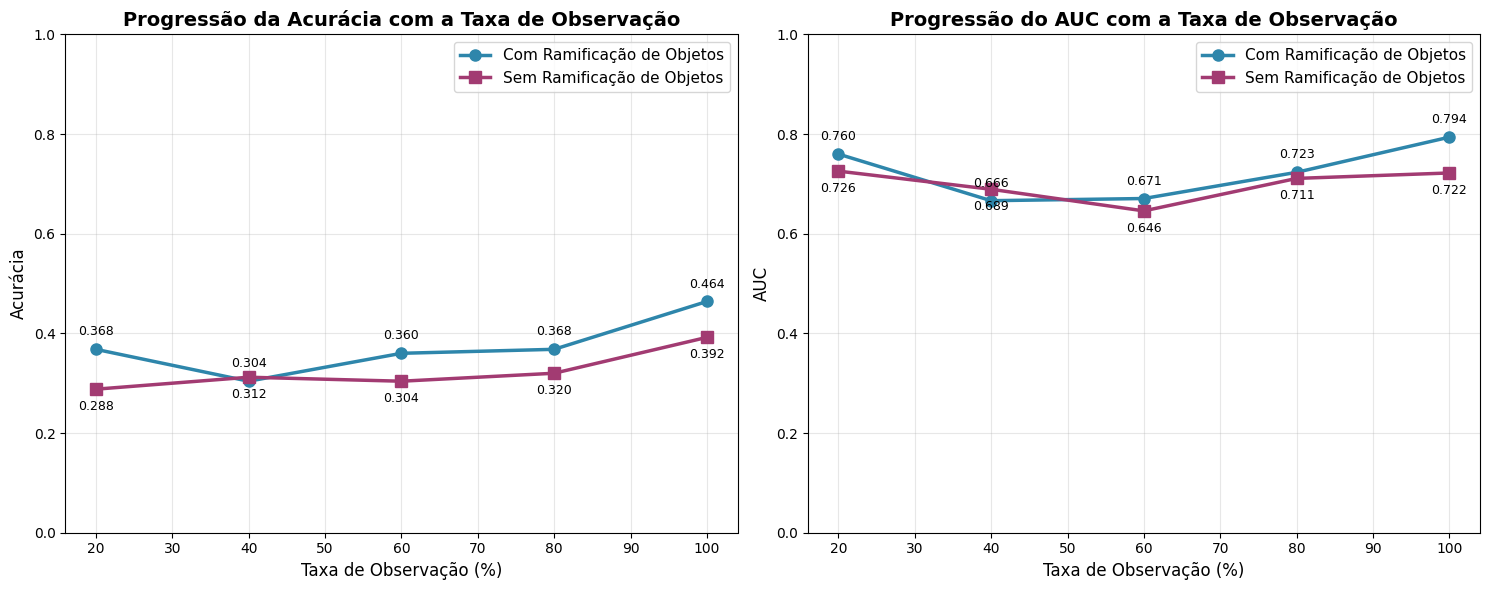


QUANTITATIVE METRICS SUMMARY TABLE
Obs Rate   With Obj Acc Without Obj Acc With Obj AUC Without Obj AUC
--------------------------------------------------------------------------------
100%        0.464        0.392           0.794        0.722          
80%        0.368        0.320           0.723        0.711          
60%        0.360        0.304           0.671        0.646          
40%        0.304        0.312           0.666        0.689          
20%        0.368        0.288           0.760        0.726          

PERFORMANCE DIFFERENCE ANALYSIS
Obs Rate   Acc Difference  AUC Difference 
------------------------------------------------------------
100%        0.072           0.072          
80%        0.048           0.012          
60%        0.056           0.025          
40%        -0.008          -0.023         
20%        0.080           0.034          


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_metrics_progression(dataset_validation, observation_rates):
    """
    Plot accuracy and macro AUC progression over observation rates.
    
    Args:
        dataset_validation: DatasetValidation object containing results
        observation_rates: List of observation rates (e.g., [100, 80, 60, 40, 20])
    """
    # Extract metrics
    with_obj_accuracy = []
    without_obj_accuracy = []
    with_obj_macro_auc = []
    without_obj_macro_auc = []
    
    for obs_rate in observation_rates:
        # Get validation results for this observation rate
        validation_results = dataset_validation[obs_rate]
        
        # Extract metrics for with object branch
        with_obj_metrics = validation_results.with_object_branch.quantitative_metrics
        with_obj_accuracy.append(with_obj_metrics.accuracy)
        with_obj_macro_auc.append(with_obj_metrics.macro_auc)
        
        # Extract metrics for without object branch
        without_obj_metrics = validation_results.without_object_branch.quantitative_metrics
        without_obj_accuracy.append(without_obj_metrics.accuracy)
        without_obj_macro_auc.append(without_obj_metrics.macro_auc)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Accuracy Progression
    ax1.plot(observation_rates, with_obj_accuracy, 
             marker='o', linewidth=2.5, markersize=8, 
             color='#2E86AB', label=CHARTS_LABELS.with_object_branch)
    ax1.plot(observation_rates, without_obj_accuracy, 
             marker='s', linewidth=2.5, markersize=8, 
             color='#A23B72', label=CHARTS_LABELS.without_object_branch)
    
    ax1.set_xlabel(CHARTS_LABELS.quantitative_observation_rate, fontsize=12)
    ax1.set_ylabel(CHARTS_LABELS.quantitative_accuracy, fontsize=12)
    ax1.set_title(CHARTS_LABELS.quantitative_accuracy_progression_over_observation_rate, fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)  # Accuracy is typically 0-1
    
    # Add value annotations
    for i, (obs_rate, with_acc, without_acc) in enumerate(zip(observation_rates, with_obj_accuracy, without_obj_accuracy)):
        ax1.annotate(f'{with_acc:.3f}', 
                    (obs_rate, with_acc), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)
        ax1.annotate(f'{without_acc:.3f}', 
                    (obs_rate, without_acc), 
                    textcoords="offset points", 
                    xytext=(0,-15), 
                    ha='center', fontsize=9)
    
    # Plot 2: Macro AUC Progression
    ax2.plot(observation_rates, with_obj_macro_auc, 
             marker='o', linewidth=2.5, markersize=8, 
             color='#2E86AB', label=CHARTS_LABELS.with_object_branch)
    ax2.plot(observation_rates, without_obj_macro_auc, 
             marker='s', linewidth=2.5, markersize=8, 
             color='#A23B72', label=CHARTS_LABELS.without_object_branch)
    
    ax2.set_xlabel(CHARTS_LABELS.quantitative_observation_rate, fontsize=12)
    ax2.set_ylabel(CHARTS_LABELS.quantitative_auc, fontsize=12)
    ax2.set_title(CHARTS_LABELS.quantitative_auc_progression_over_observation_rate, fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)  # AUC is typically 0-1
    
    # Add value annotations
    for i, (obs_rate, with_auc, without_auc) in enumerate(zip(observation_rates, with_obj_macro_auc, without_obj_macro_auc)):
        ax2.annotate(f'{with_auc:.3f}', 
                    (obs_rate, with_auc), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)
        ax2.annotate(f'{without_auc:.3f}', 
                    (obs_rate, without_auc), 
                    textcoords="offset points", 
                    xytext=(0,-15), 
                    ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("QUANTITATIVE METRICS SUMMARY TABLE")
    print("="*80)
    print(f"{'Obs Rate':<10} {'With Obj Acc':<12} {'Without Obj Acc':<15} {'With Obj AUC':<12} {'Without Obj AUC':<15}")
    print("-"*80)
    
    for i, obs_rate in enumerate(observation_rates):
        print(f"{obs_rate}%{'':<7} {with_obj_accuracy[i]:<12.3f} {without_obj_accuracy[i]:<15.3f} "
              f"{with_obj_macro_auc[i]:<12.3f} {without_obj_macro_auc[i]:<15.3f}")
    
    # Calculate performance differences
    print("\n" + "="*60)
    print("PERFORMANCE DIFFERENCE ANALYSIS")
    print("="*60)
    print(f"{'Obs Rate':<10} {'Acc Difference':<15} {'AUC Difference':<15}")
    print("-"*60)
    
    for i, obs_rate in enumerate(observation_rates):
        acc_diff = with_obj_accuracy[i] - without_obj_accuracy[i]
        auc_diff = with_obj_macro_auc[i] - without_obj_macro_auc[i]
        print(f"{obs_rate}%{'':<7} {acc_diff:<15.3f} {auc_diff:<15.3f}")

# Usage in your notebook
plot_quantitative_metrics_progression(dataset_validation, OBSERVATION_RATE)

### Qualitative Comparison

- Graphic Analysis - Plotting with t-SNE
- Progression over observation rate

#### EAR (Early Action Recognition) Validation

t-SNE Visualization for Observation Rate: 100%


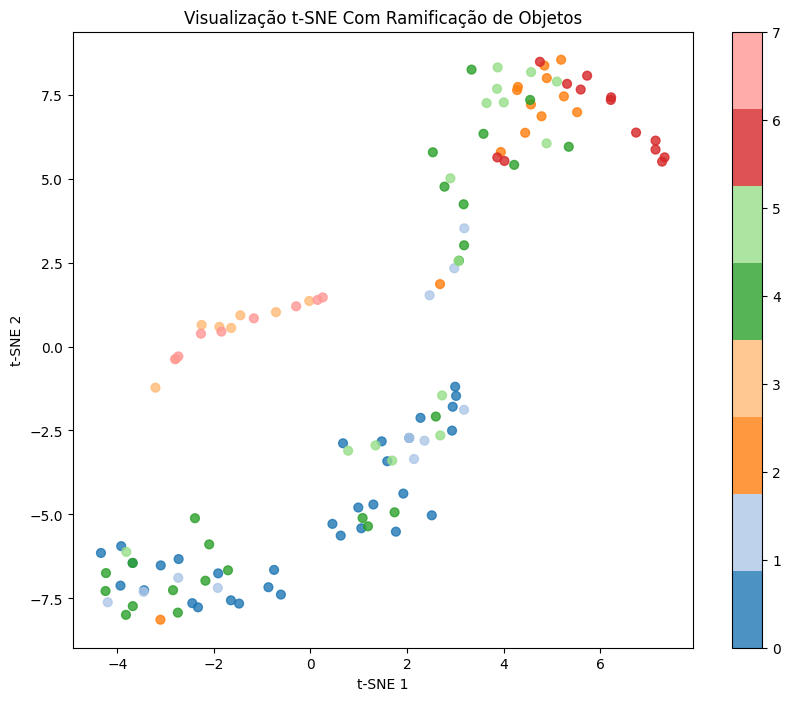

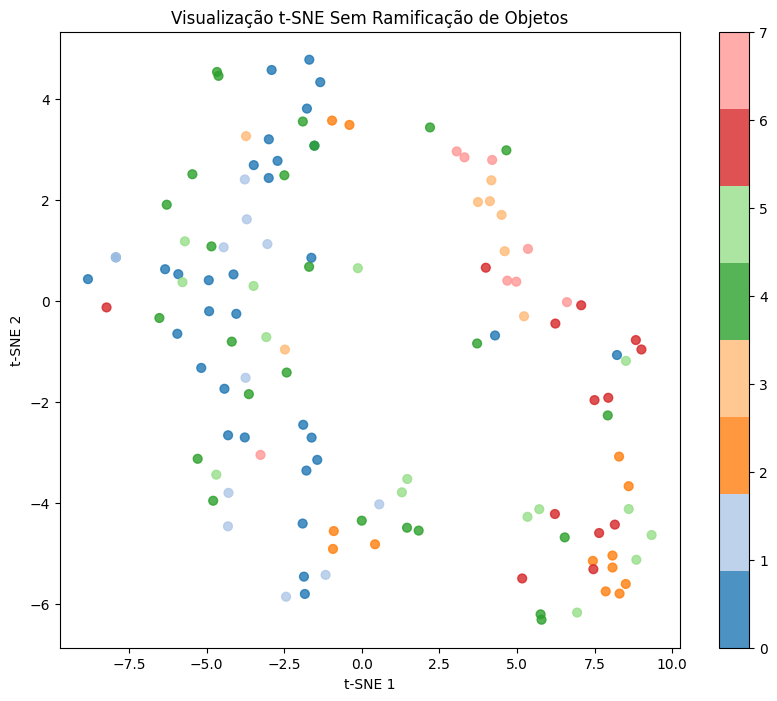

--------------------------------------------------
t-SNE Visualization for Observation Rate: 80%


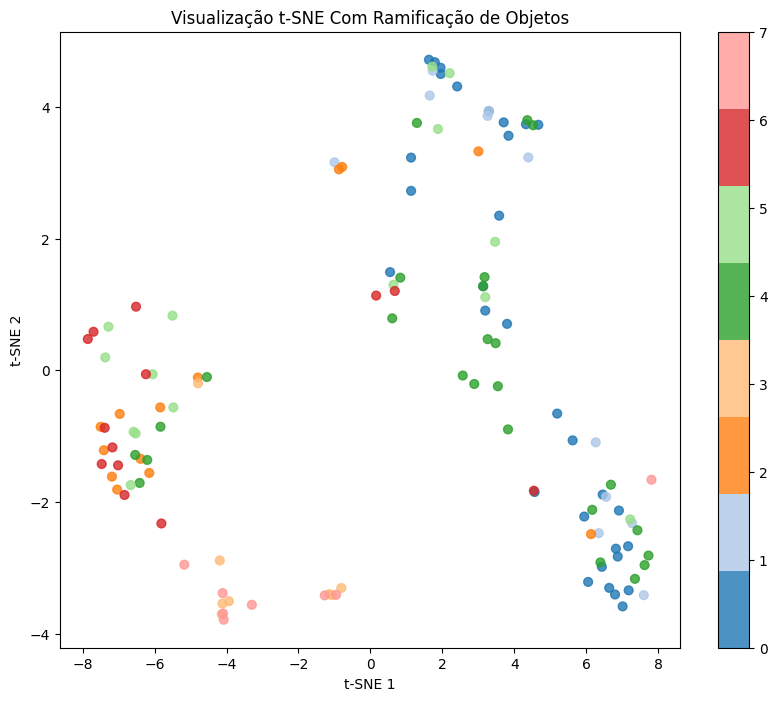

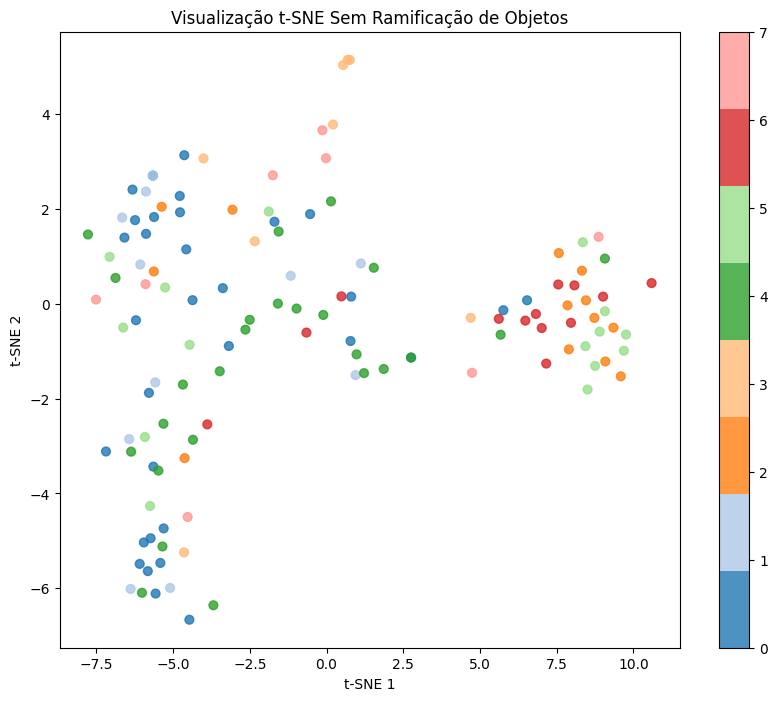

--------------------------------------------------
t-SNE Visualization for Observation Rate: 60%


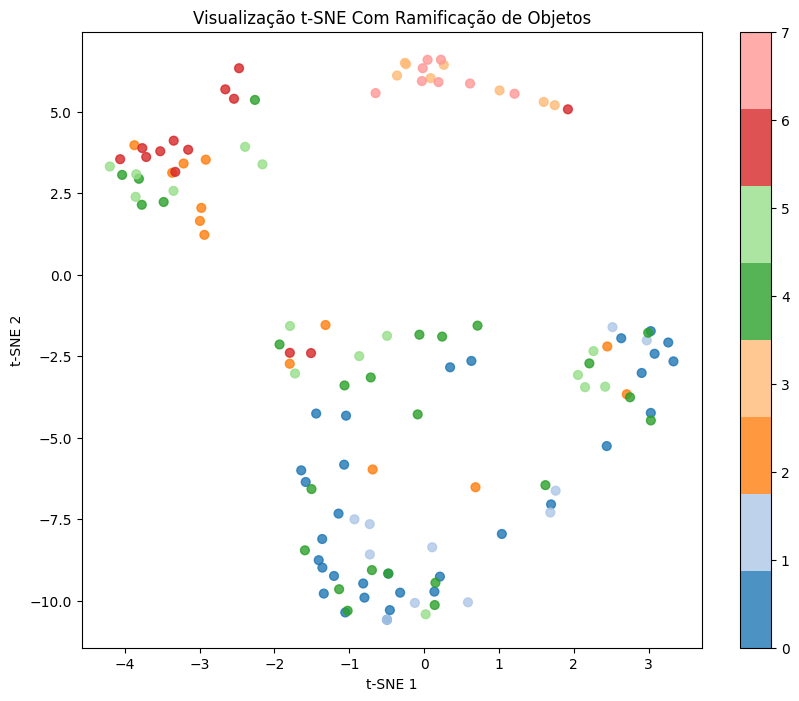

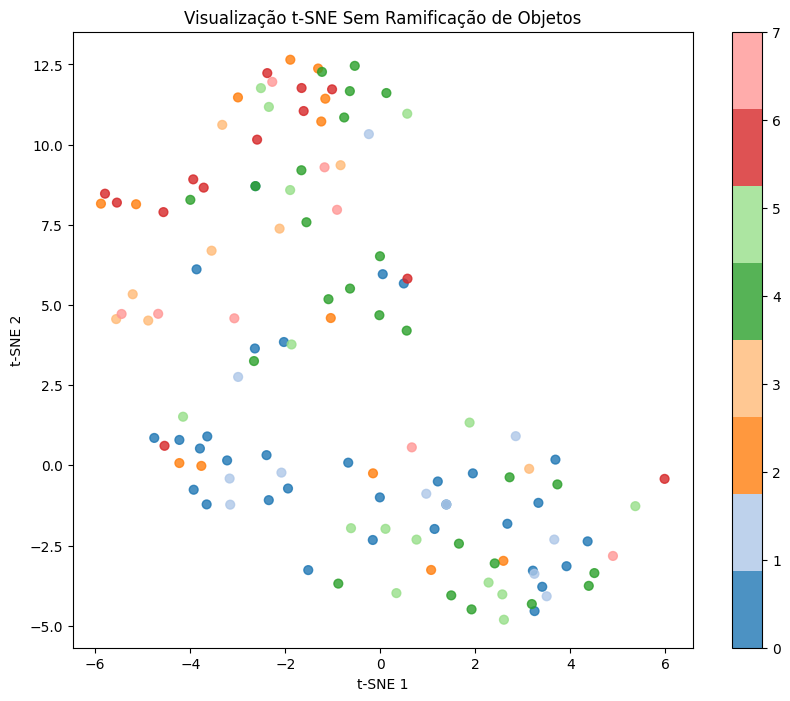

--------------------------------------------------
t-SNE Visualization for Observation Rate: 40%


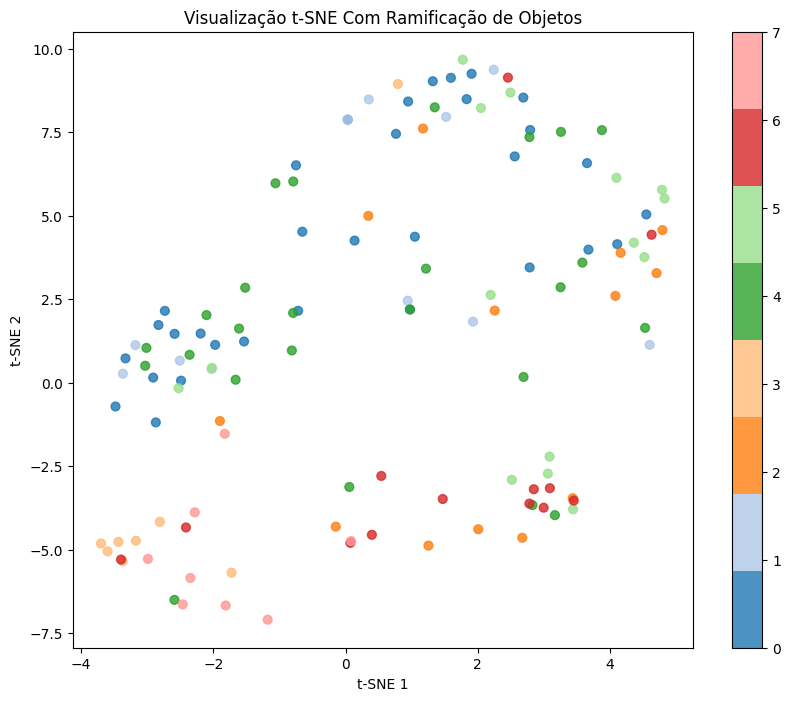

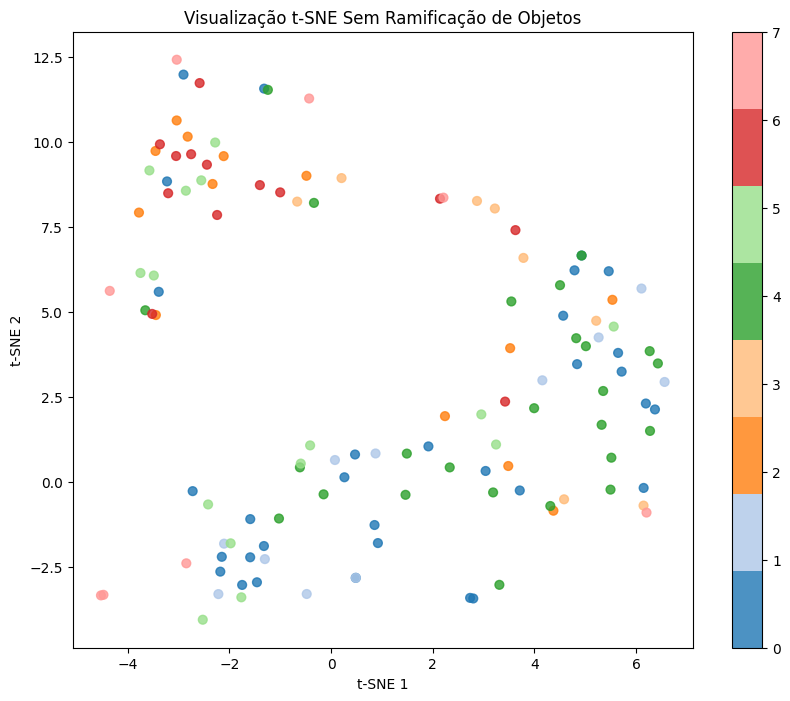

--------------------------------------------------
t-SNE Visualization for Observation Rate: 20%


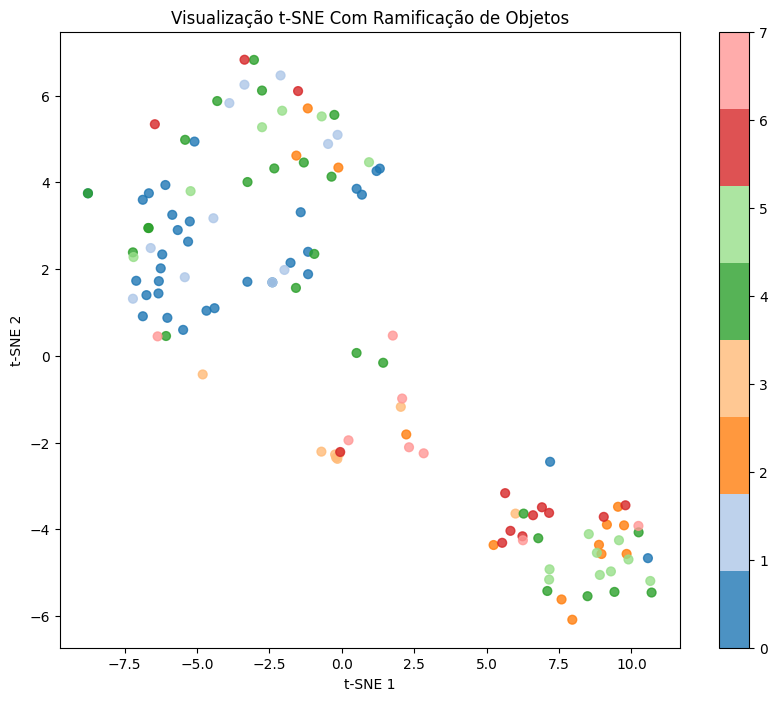

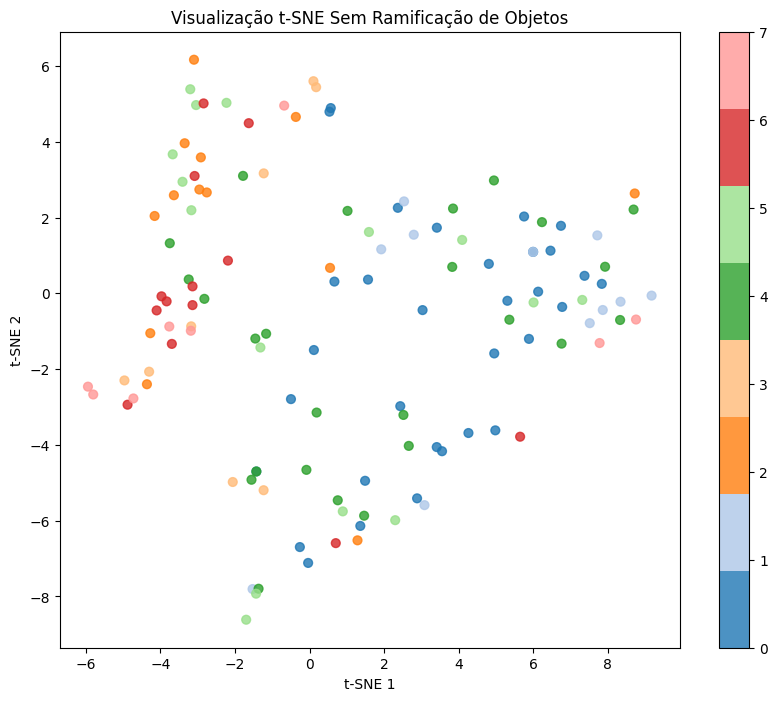

--------------------------------------------------


In [10]:
from sklearn.manifold import TSNE
perplexity = 30
random_state = 42
t_sne_components = 2

for obs_rate in OBSERVATION_RATE:
    embeddings, labels = dataset_validation[obs_rate].with_object_branch.embeddings
    embeddings_without_object, labels_without_object = dataset_validation[obs_rate].without_object_branch.embeddings


    tsne = TSNE(
        n_components=t_sne_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced = tsne.fit_transform(embeddings)

    tsne_without_object = TSNE(
        n_components=t_sne_components,
        perplexity=perplexity,
        random_state=random_state,
        init="pca"
    )
    reduced_without_object = tsne_without_object.fit_transform(embeddings_without_object)
    
    print(f"t-SNE Visualization for Observation Rate: {obs_rate}%")
    visualize_tsne(
        reduced,
        labels,
        num_classes=8,
        n_components=t_sne_components,
        title=CHARTS_LABELS.t_sne_visualization + " " + CHARTS_LABELS.with_object_branch
    )
    visualize_tsne(
        reduced_without_object,
        labels_without_object,
        num_classes=8,
        n_components=t_sne_components,
        title=CHARTS_LABELS.t_sne_visualization + " " + CHARTS_LABELS.without_object_branch
    )
    print("--------------------------------------------------")

## Confusion Matrix

Confusion matrix will be only plotted for 100% trained models

In [11]:
from validation.confusion_matrix import calculate_confusion_matrix


har_model, _ = MultiModalHARModel.load(
    checkpoint_path=MODELS_PHT[100]["with_obj"]
)
cm = calculate_confusion_matrix(har_model, validation_dataset, device="cpu")

har_model_without_object, _ = MultiModalHARModel.load(
    checkpoint_path=MODELS_PHT[100]["without_obj"]
)
cm_without_object = calculate_confusion_matrix(har_model_without_object, validation_dataset, device="cpu")

2025-12-30 11:50:45,620 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_with_obj_20251207_145531.pht...
2025-12-30 11:50:45,885 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:45,886 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-30 11:50:45,929 - INFO - ✅ Model loaded and ready for inference
2025-12-30 11:50:49,551 - INFO - Loading model from /Volumes/KODAK/master

In [12]:
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[27  5  0  0  0  0  0  0]
 [ 6  2  0  0  2  1  0  0]
 [ 1  0 11  0  0  1  0  0]
 [ 0  0  0  6  0  0  0  2]
 [14  1  6  0  4  0  0  0]
 [ 4  2  7  0  2  0  0  0]
 [ 0  0  8  0  0  0  5  0]
 [ 0  0  0  5  0  0  0  3]]


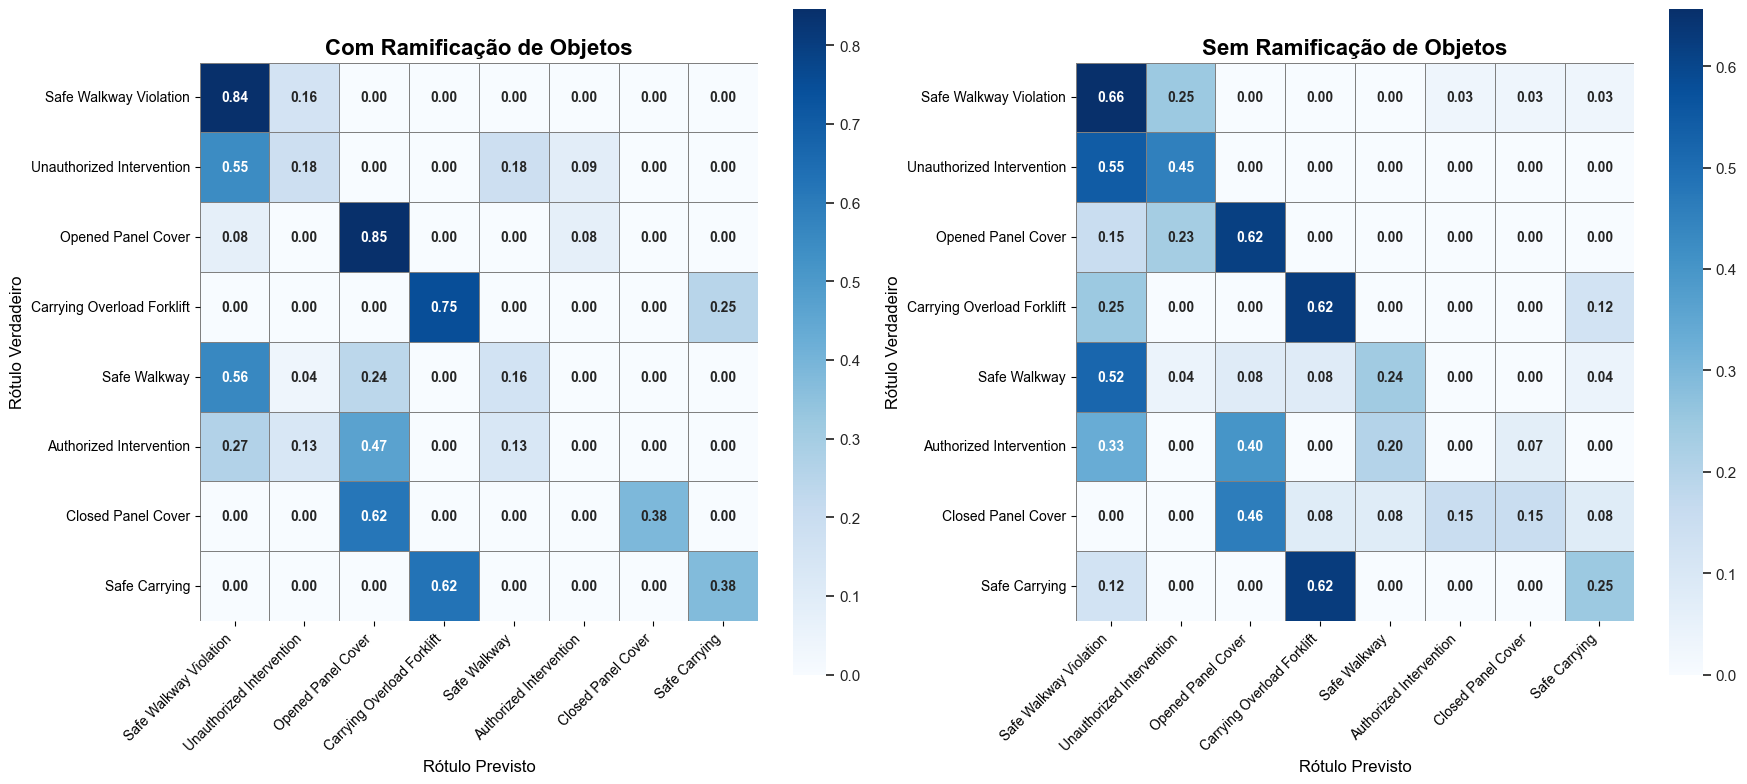

In [13]:
from validation.actions_map import UNSAFE_NET_ORDERED
from validation.plots import plot_confusion_matrix


plot_confusion_matrix(
    cm,
    class_names=UNSAFE_NET_ORDERED,
    without_object_cm=cm_without_object,
)